In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gp
import seaborn as sns
import json
import datetime as dt
from collections import namedtuple
from pathlib import Path

In [2]:
month_map = dict(
    zip(
        [dt.date(2000, ii+1, 1).strftime('%B') for ii in range(12)],
        range(1, 13)))
month_map

{'January': 1,
 'February': 2,
 'March': 3,
 'April': 4,
 'May': 5,
 'June': 6,
 'July': 7,
 'August': 8,
 'September': 9,
 'October': 10,
 'November': 11,
 'December': 12}

### Load climate normals from NCEI

In [4]:
AK_normals_df = pd.read_csv("/Volumes/CWMobileSSD/Climate/normals_AK_month_81_10/2716059.csv")
AK_normals_df

STATION             NAME  LATITUDE  LONGITUDE  ELEVATION  DATE  \
0     USC00509829  WHITTIER, AK US  60.77639 -148.68583       18.3     1   
1     USC00509829  WHITTIER, AK US  60.77639 -148.68583       18.3     2   
2     USC00509829  WHITTIER, AK US  60.77639 -148.68583       18.3     3   
3     USC00509829  WHITTIER, AK US  60.77639 -148.68583       18.3     4   
4     USC00509829  WHITTIER, AK US  60.77639 -148.68583       18.3     5   
...           ...              ...       ...        ...        ...   ...   
2059  USC00507141   PELICAN, AK US  57.95770 -136.22130        3.7     8   
2060  USC00507141   PELICAN, AK US  57.95770 -136.22130        3.7     9   
2061  USC00507141   PELICAN, AK US  57.95770 -136.22130        3.7    10   
2062  USC00507141   PELICAN, AK US  57.95770 -136.22130        3.7    11   
2063  USC00507141   PELICAN, AK US  57.95770 -136.22130        3.7    12   

      MLY-DUTR-NORMAL MLY-DUTR-NORMAL_ATTRIBUTES  MLY-DUTR-STDDEV  \
0                 7.7                          S              1.7   
1                 7.5                          S              1.6   
2                 8.3                          S              1.2   
3                 9.8                          S              1.1   
4                11.8                          S              2.0   
...               ...                        ...              ...   
2059             12.5                          R              3.2   
2060             12.4                          R              2.6   
2061             10.0                          R              1.3   
2062              8.4                          R              1.4   
2063              7.5                          R              1.1   

     MLY-DUTR-STDDEV_ATTRIBUTES  ...  MLY-TMIN-PRBOCC-LSTH024  \
0                             S  ...                    990.0   
1                             S  ...                    992.0   
2                             S  ...                    954.0   
3                             S  ...                    477.0   
4                             S  ...                      0.0   
...                         ...  ...                      ...   
2059                          R  ...                      0.0   
2060                          R  ...                      0.0   
2061                          R  ...                    122.0   
2062                          R  ...                    679.0   
2063                          R  ...                    950.0   

     MLY-TMIN-PRBOCC-LSTH024_ATTRIBUTES  MLY-TMIN-PRBOCC-LSTH028  \
0                                     S                    999.0   
1                                     S                    999.0   
2                                     S                    996.0   
3                                     S                    764.0   
4                                     S                      0.0   
...                                 ...                      ...   
2059                                  R                      0.0   
2060                                  R                     10.0   
2061                                  R                    463.0   
2062                                  R                    931.0   
2063                                  R                   1000.0   

     MLY-TMIN-PRBOCC-LSTH028_ATTRIBUTES  MLY-TMIN-PRBOCC-LSTH032  \
0                                     S                   1000.0   
1                                     S                   1000.0   
2                                     S                   1000.0   
3                                     S                    974.0   
4                                     S                    192.0   
...                                 ...                      ...   
2059                                  R                      0.0   
2060                                  R                    139.0   
2061                                  R                   

Drop the stations that have no data in the monthly temperature normal. 

In [5]:
AK_normals_df.dropna(subset=['MLY-TAVG-NORMAL'], inplace=True)

In [6]:
AK_normals_df.keys()

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE',
       'MLY-DUTR-NORMAL', 'MLY-DUTR-NORMAL_ATTRIBUTES', 'MLY-DUTR-STDDEV',
       'MLY-DUTR-STDDEV_ATTRIBUTES', 'MLY-PRCP-NORMAL',
       'MLY-PRCP-NORMAL_ATTRIBUTES', 'MLY-SNOW-NORMAL',
       'MLY-SNOW-NORMAL_ATTRIBUTES', 'MLY-SNWD-AVGNDS-GE003WI',
       'MLY-SNWD-AVGNDS-GE003WI_ATTRIBUTES', 'MLY-SNWD-AVGNDS-GE005WI',
       'MLY-SNWD-AVGNDS-GE005WI_ATTRIBUTES', 'MLY-TAVG-NORMAL',
       'MLY-TAVG-NORMAL_ATTRIBUTES', 'MLY-TAVG-STDDEV',
       'MLY-TAVG-STDDEV_ATTRIBUTES', 'MLY-TMAX-NORMAL',
       'MLY-TMAX-NORMAL_ATTRIBUTES', 'MLY-TMAX-STDDEV',
       'MLY-TMAX-STDDEV_ATTRIBUTES', 'MLY-TMIN-NORMAL',
       'MLY-TMIN-NORMAL_ATTRIBUTES', 'MLY-TMIN-PRBOCC-LSTH016',
       'MLY-TMIN-PRBOCC-LSTH016_ATTRIBUTES', 'MLY-TMIN-PRBOCC-LSTH020',
       'MLY-TMIN-PRBOCC-LSTH020_ATTRIBUTES', 'MLY-TMIN-PRBOCC-LSTH024',
       'MLY-TMIN-PRBOCC-LSTH024_ATTRIBUTES', 'MLY-TMIN-PRBOCC-LSTH028',
       'MLY-TMIN-PRBOCC-LSTH028_ATTRI

Simplify station names, and attract just the station location and name data. 

In [7]:
AK_normals_df.NAME = AK_normals_df.NAME.str.replace(", AK US", "")
AK_stations = AK_normals_df.loc[:,["NAME", "LATITUDE", "LONGITUDE", "STATION"]].drop_duplicates()
AK_stations.reset_index(drop=True)

NAME  LATITUDE  LONGITUDE      STATION
0               WHITTIER  60.77639 -148.68583  USC00509829
1                   HOPE  60.89830 -149.62860  USC00503720
2        ILIAMNA AIRPORT  59.74940 -154.90890  USW00025506
3              KITOI BAY  58.19130 -152.37220  USC00504812
4    KING SALMON AIRPORT  58.68290 -156.65630  USW00025503
..                   ...       ...        ...          ...
158   MANLEY HOT SPRINGS  64.99880 -150.63800  USC00505644
159              CHICKEN  64.09170 -141.92110  USC00501684
160             FOX 2 SE  64.95910 -147.62610  USC00503181
161        SNOWSHOE LAKE  62.03020 -146.69300  USC00508594
162              PELICAN  57.95770 -136.22130  USC00507141

[163 rows x 4 columns]

Note that there are two separate stations at Portage Glacier Visitor Center... 

In [8]:
AK_normals_df.loc[AK_normals_df.NAME.str.startswith("PORTAGE"),["NAME", "STATION", "LATITUDE", "LONGITUDE"]]

NAME      STATION  LATITUDE  LONGITUDE
564   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
565   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
566   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
567   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
568   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
569   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
570   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
571   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
572   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
573   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
574   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
575   PORTAGE GLACIER VISITOR CENTER  USW00026492  60.78500 -148.83889
1128  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1129  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1130  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1131  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1132  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1133  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1134  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1135  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1136  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1137  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1138  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333
1139  PORTAGE GLACIER VISITOR CENTER  USC00507502  60.78333 -148.83333

### Google Earth Engine to retrieve ERA5 data

In [3]:
import ee

In [9]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWg4ECoS_NJjpguA0czeebpnTPm5laNR0b5KYSAe5n_yuupJ6dDqWX0



Successfully saved authorization token.


Build a list of objects for GEE

In [10]:
AK_stations.to_records(index=False)

rec.array([('WHITTIER', 60.77639, -148.68583, 'USC00509829'),
           ('HOPE', 60.8983 , -149.6286 , 'USC00503720'),
           ('ILIAMNA AIRPORT', 59.7494 , -154.9089 , 'USW00025506'),
           ('KITOI BAY', 58.1913 , -152.3722 , 'USC00504812'),
           ('KING SALMON AIRPORT', 58.6829 , -156.6563 , 'USW00025503'),
           ('COLD BAY AIRPORT', 55.22083, -162.7325 , 'USW00025624'),
           ('SOLDOTNA 5 SSW', 60.4194 , -151.1336 , 'USC00508615'),
           ('SEWARD AIRPORT', 60.12833, -149.41667, 'USW00026438'),
           ('DEADHORSE AIRPORT', 70.1917 , -148.4772 , 'USW00027406'),
           ('KODIAK AIRPORT', 57.75111, -152.48556, 'USW00025501'),
           ('NENANA MUNICIPAL AIRPORT', 64.55   , -149.07167, 'USW00026435'),
           ('GLACIER BAY', 58.4561 , -135.8692 , 'USC00503294'),
           ('TOK', 63.3337 , -143.0372 , 'USC00509313'),
           ('GLEN ALPS', 61.1    , -149.6936 , 'USC00503299'),
           ('HOONAH', 58.1071 , -135.4277 , 'USC00503695'),
       

In [11]:
features = [ 
    ee.Feature(ee.Geometry.Point(rec.LONGITUDE , rec.LATITUDE), {'name': rec.NAME}) for rec in AK_stations.to_records(index=False)
]

# for prototyping
locs_small = ee.FeatureCollection(features[5:10])

In [22]:
locs_small.getInfo()

{'type': 'FeatureCollection',
 'columns': {'name': 'String', 'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-162.7325, 55.22083]},
   'id': '0',
   'properties': {'name': 'COLD BAY AIRPORT'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-151.1336, 60.4194]},
   'id': '1',
   'properties': {'name': 'SOLDOTNA 5 SSW'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-149.41667, 60.12833]},
   'id': '2',
   'properties': {'name': 'SEWARD AIRPORT'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-148.4772, 70.1917]},
   'id': '3',
   'properties': {'name': 'DEADHORSE AIRPORT'}},
  {'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-152.48556, 57.75111]},
   'id': '4',
   'properties': {'name': 'KODIAK AIRPORT'}}]}

In [12]:
ERA5_LAND_month = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY").filterDate('1981-01-01', '2010-12-31')

In [13]:
months = ee.List.sequence(1, 12)

In [14]:
from itertools import islice

def grouper(n, iterable):
    it = iter(iterable)
    return iter(lambda: tuple(islice(it, n)), ())

In [15]:
for sublist in grouper(5, month_map.keys()):
    print(list(sublist))

['January', 'February', 'March', 'April', 'May']
['June', 'July', 'August', 'September', 'October']
['November', 'December']


In [20]:
def ERA5_LAND_monthly_swe(m):
    return (
        ERA5_LAND_month
        .filter(ee.Filter.calendarRange(m, m, 'month'))
        .select('snow_depth_water_equivalent')
        .mean()
        .set('month', m))

def generate_sampleImgByLocs(featurelist):
    def sampleImgByLocs(img, scale=30):
        return img.sampleRegions(ee.FeatureCollection(featurelist), scale=scale)
    return sampleImgByLocs

#def sampleImgByLocs_small(img):
#    return generate_sampleImgByLocs(features[5:10])

sampleImgByLocs_small = generate_sampleImgByLocs(features[5:10])

#def sampleImgByLocs(img):
#    return img.sampleRegions(locs, scale=30)

Prototyping

In [21]:
swembyMonth = ee.ImageCollection.fromImages(
    months.map(ERA5_LAND_monthly_swe))

stationsSWEAvg = swembyMonth.map(sampleImgByLocs_small).flatten()

In [22]:
ERA5_SWEavg_bystation = stationsSWEAvg.getInfo()
ERA5_SWEavg_bystation

{'type': 'FeatureCollection',
 'columns': {},
 'features': [{'type': 'Feature',
   'geometry': None,
   'id': '0_1_0',
   'properties': {'name': 'SOLDOTNA 5 SSW',
    'snow_depth_water_equivalent': 0.13764530817667645}},
  {'type': 'Feature',
   'geometry': None,
   'id': '0_2_0',
   'properties': {'name': 'SEWARD AIRPORT',
    'snow_depth_water_equivalent': 0.7347180048624674}},
  {'type': 'Feature',
   'geometry': None,
   'id': '0_3_0',
   'properties': {'name': 'DEADHORSE AIRPORT',
    'snow_depth_water_equivalent': 0.06987263361612955}},
  {'type': 'Feature',
   'geometry': None,
   'id': '0_4_0',
   'properties': {'name': 'KODIAK AIRPORT',
    'snow_depth_water_equivalent': 0.06247215270996094}},
  {'type': 'Feature',
   'geometry': None,
   'id': '1_1_0',
   'properties': {'name': 'SOLDOTNA 5 SSW',
    'snow_depth_water_equivalent': 0.18963069915771485}},
  {'type': 'Feature',
   'geometry': None,
   'id': '1_2_0',
   'properties': {'name': 'SEWARD AIRPORT',
    'snow_depth_wate

Getting data for all locations, but in batches to avoid timeouts

In [23]:
batch = 20
feature = namedtuple('Feature', ['id', 'name', 'snow_depth_water_equivalent'])

In [24]:
SWEmbyMonth = ee.ImageCollection.fromImages(
    months.map(ERA5_LAND_monthly_swe))

In [26]:
batchnum = 0
for featurebatch in grouper(batch, features):
    batchnum += 1
    print(f"Working on batch {batchnum}")
    sampleImgByLocs_batch = generate_sampleImgByLocs(featurebatch)
    stationsSWEAvg = SWEmbyMonth.map(sampleImgByLocs_batch).flatten()
    ERA5_LAND_SWEAvg_bystation = stationsSWEAvg.getInfo()
    ERA5_LAND_SWEs = pd.DataFrame(
    [feature(item['id'], item['properties']['name'], item['properties']['snow_depth_water_equivalent']) 
        for item in ERA5_LAND_SWEAvg_bystation['features']], columns=feature._fields)
    try: 
        ERA5_SWE_all = ERA5_SWE_all.append(ERA5_LAND_SWEs)
    except NameError:
        ERA5_SWE_all = ERA5_LAND_SWEs

Working on batch 1
Working on batch 2
Working on batch 3
Working on batch 4
Working on batch 5
Working on batch 6
Working on batch 7
Working on batch 8
Working on batch 9


In [27]:
ERA5_SWE_all

id                 name  snow_depth_water_equivalent
0    0_0_0             WHITTIER                     4.029733
1    0_1_0                 HOPE                     0.454423
2    0_2_0      ILIAMNA AIRPORT                     0.065145
3    0_3_0            KITOI BAY                     0.009480
4    0_4_0  KING SALMON AIRPORT                     0.046826
..     ...                  ...                          ...
31  10_1_0        SNOWSHOE LAKE                     0.085008
32  10_2_0              PELICAN                     0.031328
33  11_0_0             FOX 2 SE                     0.044232
34  11_1_0        SNOWSHOE LAKE                     0.153585
35  11_2_0              PELICAN                     0.109610

[1716 rows x 3 columns]

In [28]:
ERA5_SWE_all['month'] = ERA5_SWE_all.id.str.split('_').str.get(0).astype('int') + 1
ERA5_SWE_all.drop(columns=['id'], inplace=True)
ERA5_SWE_all.head()

name  snow_depth_water_equivalent  month
0             WHITTIER                     4.029733      1
1                 HOPE                     0.454423      1
2      ILIAMNA AIRPORT                     0.065145      1
3            KITOI BAY                     0.009480      1
4  KING SALMON AIRPORT                     0.046826      1

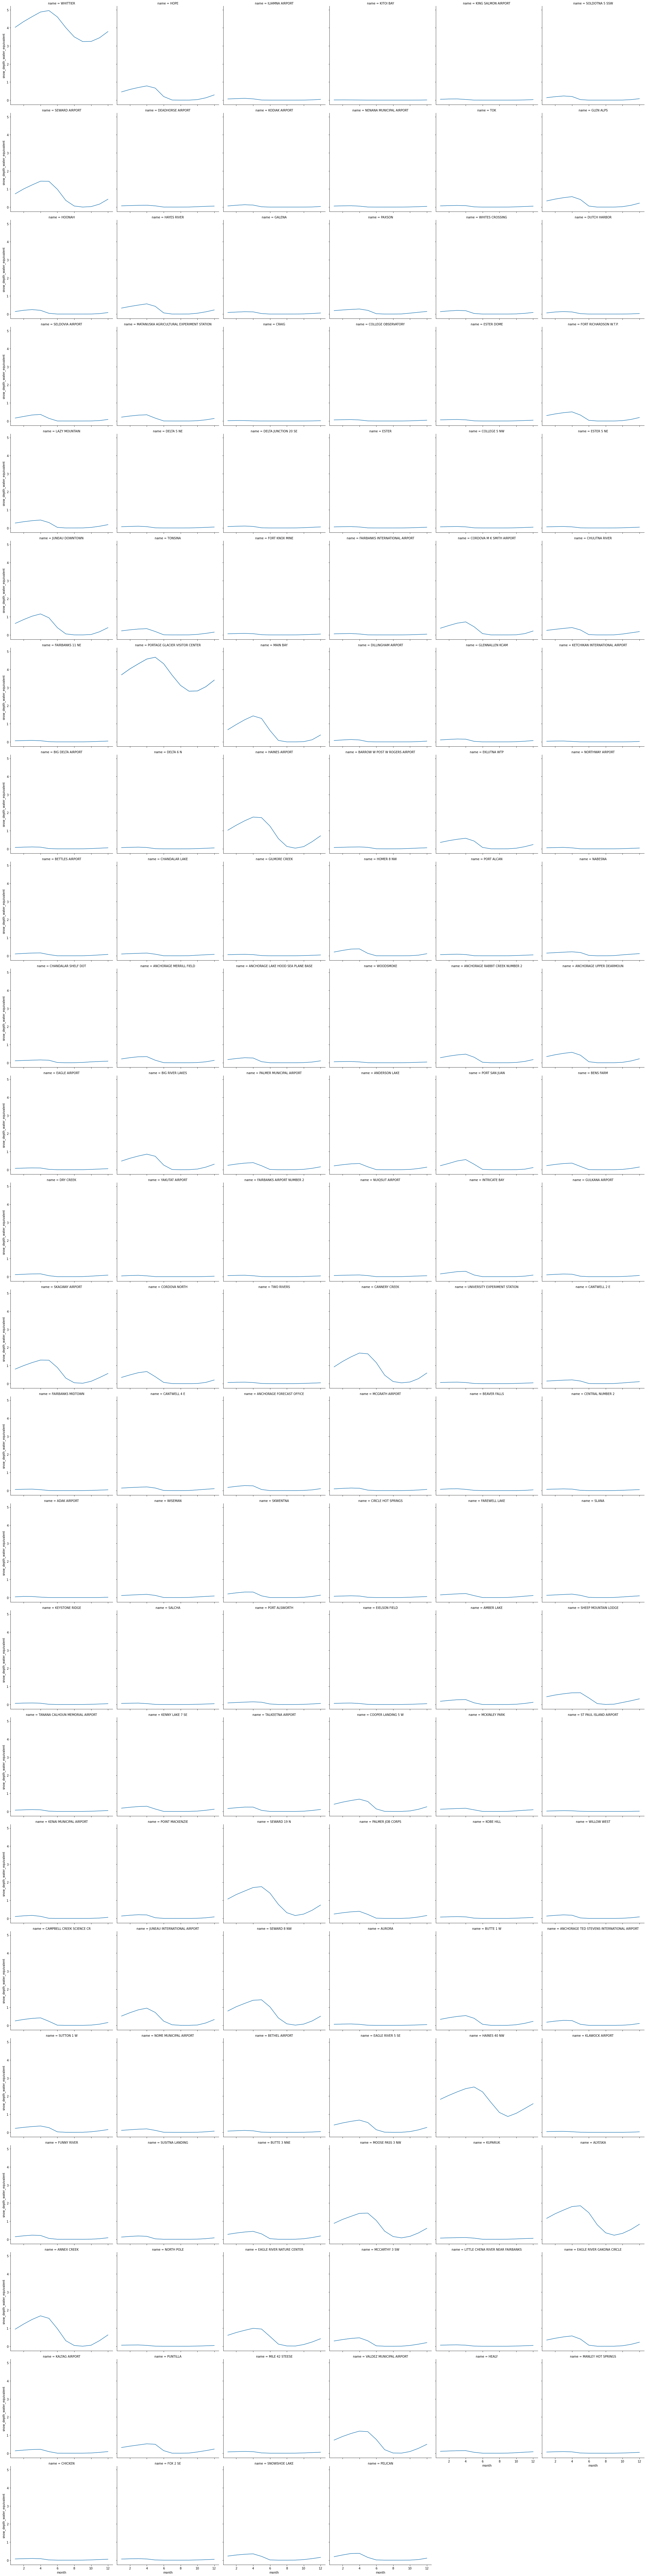

In [37]:
sns.relplot(data=ERA5_SWE_all, x='month', y='snow_depth_water_equivalent', 
            kind="line",
            col='name', col_wrap=6) 

In [79]:
AK_tavg_normals = AK_normals_df[['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE',
       'MLY-TAVG-NORMAL',]] 
AK_tavg_normals.columns = ['station', 'name', 'lat', 'lon', 'ele', 'month', 't_avg_month']
AK_tavg_normals

station      name       lat        lon   ele  month  t_avg_month
0     USC00509829  WHITTIER  60.77639 -148.68583  18.3      1         28.5
1     USC00509829  WHITTIER  60.77639 -148.68583  18.3      2         29.3
2     USC00509829  WHITTIER  60.77639 -148.68583  18.3      3         32.4
3     USC00509829  WHITTIER  60.77639 -148.68583  18.3      4         38.8
4     USC00509829  WHITTIER  60.77639 -148.68583  18.3      5         46.8
...           ...       ...       ...        ...   ...    ...          ...
2059  USC00507141   PELICAN  57.95770 -136.22130   3.7      8         56.0
2060  USC00507141   PELICAN  57.95770 -136.22130   3.7      9         50.9
2061  USC00507141   PELICAN  57.95770 -136.22130   3.7     10         42.9
2062  USC00507141   PELICAN  57.95770 -136.22130   3.7     11         35.2
2063  USC00507141   PELICAN  57.95770 -136.22130   3.7     12         32.3

[1956 rows x 7 columns]

In [80]:
AK_tavg_normals.t_avg_month = (AK_tavg_normals.t_avg_month - 32) / 1.8
AK_tavg_normals

/Users/cwaigl/miniconda3/envs/python38_geo/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


station      name       lat        lon   ele  month  t_avg_month
0     USC00509829  WHITTIER  60.77639 -148.68583  18.3      1    -1.944444
1     USC00509829  WHITTIER  60.77639 -148.68583  18.3      2    -1.500000
2     USC00509829  WHITTIER  60.77639 -148.68583  18.3      3     0.222222
3     USC00509829  WHITTIER  60.77639 -148.68583  18.3      4     3.777778
4     USC00509829  WHITTIER  60.77639 -148.68583  18.3      5     8.222222
...           ...       ...       ...        ...   ...    ...          ...
2059  USC00507141   PELICAN  57.95770 -136.22130   3.7      8    13.333333
2060  USC00507141   PELICAN  57.95770 -136.22130   3.7      9    10.500000
2061  USC00507141   PELICAN  57.95770 -136.22130   3.7     10     6.055556
2062  USC00507141   PELICAN  57.95770 -136.22130   3.7     11     1.777778
2063  USC00507141   PELICAN  57.95770 -136.22130   3.7     12     0.166667

[1956 rows x 7 columns]

In [48]:
ERA5_SWE_all

name  snow_depth_water_equivalent  month
0              WHITTIER                     4.029733      1
1                  HOPE                     0.454423      1
2       ILIAMNA AIRPORT                     0.065145      1
3             KITOI BAY                     0.009480      1
4   KING SALMON AIRPORT                     0.046826      1
..                  ...                          ...    ...
31        SNOWSHOE LAKE                     0.085008     11
32              PELICAN                     0.031328     11
33             FOX 2 SE                     0.044232     12
34        SNOWSHOE LAKE                     0.153585     12
35              PELICAN                     0.109610     12

[1716 rows x 3 columns]

### Joining and plotting

In [81]:
joint_data = pd.merge(AK_tavg_normals, ERA5_temps_all, 
                      how='right', 
                      left_on=['name', 'month'], right_on=['name', 'month'])
joint_data.columns = ['station', 'name', 'lat', 'lon', 'ele', 'month', 
                      'station_normal_T_mean', 'ERA5_T_mean' ]

In [82]:
joint_data

station                 name       lat        lon    ele  month  \
0     USC00509829             WHITTIER  60.77639 -148.68583   18.3      1   
1     USC00503720                 HOPE  60.89830 -149.62860   54.9      1   
2     USW00025506      ILIAMNA AIRPORT  59.74940 -154.90890   43.6      1   
3     USC00504812            KITOI BAY  58.19130 -152.37220   18.3      1   
4     USW00025503  KING SALMON AIRPORT  58.68290 -156.65630   20.4      1   
...           ...                  ...       ...        ...    ...    ...   
1975  USC00508594        SNOWSHOE LAKE  62.03020 -146.69300  704.7     11   
1976  USC00507141              PELICAN  57.95770 -136.22130    3.7     11   
1977  USC00503181             FOX 2 SE  64.95910 -147.62610  236.2     12   
1978  USC00508594        SNOWSHOE LAKE  62.03020 -146.69300  704.7     12   
1979  USC00507141              PELICAN  57.95770 -136.22130    3.7     12   

      station_normal_T_mean  ERA5_T_mean  
0                 -1.944444    -9.077124  
1                 -7.611111    -9.852026  
2                 -8.055556    -7.258734  
3                 -1.111111    -0.175848  
4                 -8.777778    -7.700049  
...                     ...          ...  
1975             -16.444444   -13.503577  
1976               1.777778     1.903772  
1977             -18.500000   -17.714713  
1978             -20.500000   -17.121893  
1979               0.166667     0.555505  

[1980 rows x 8 columns]

In [83]:
rejigger = joint_data.melt(id_vars=['station', 'name', 'lat', 'lon', 'ele', 'month'], 
               value_vars=['station_normal_T_mean', 'ERA5_T_mean'],
               var_name='dataset', value_name='T_C')
rejigger.sort_values(by=['lat', 'month'], inplace=True, )

In [84]:
sns.set_context("talk", font_scale=1.2)

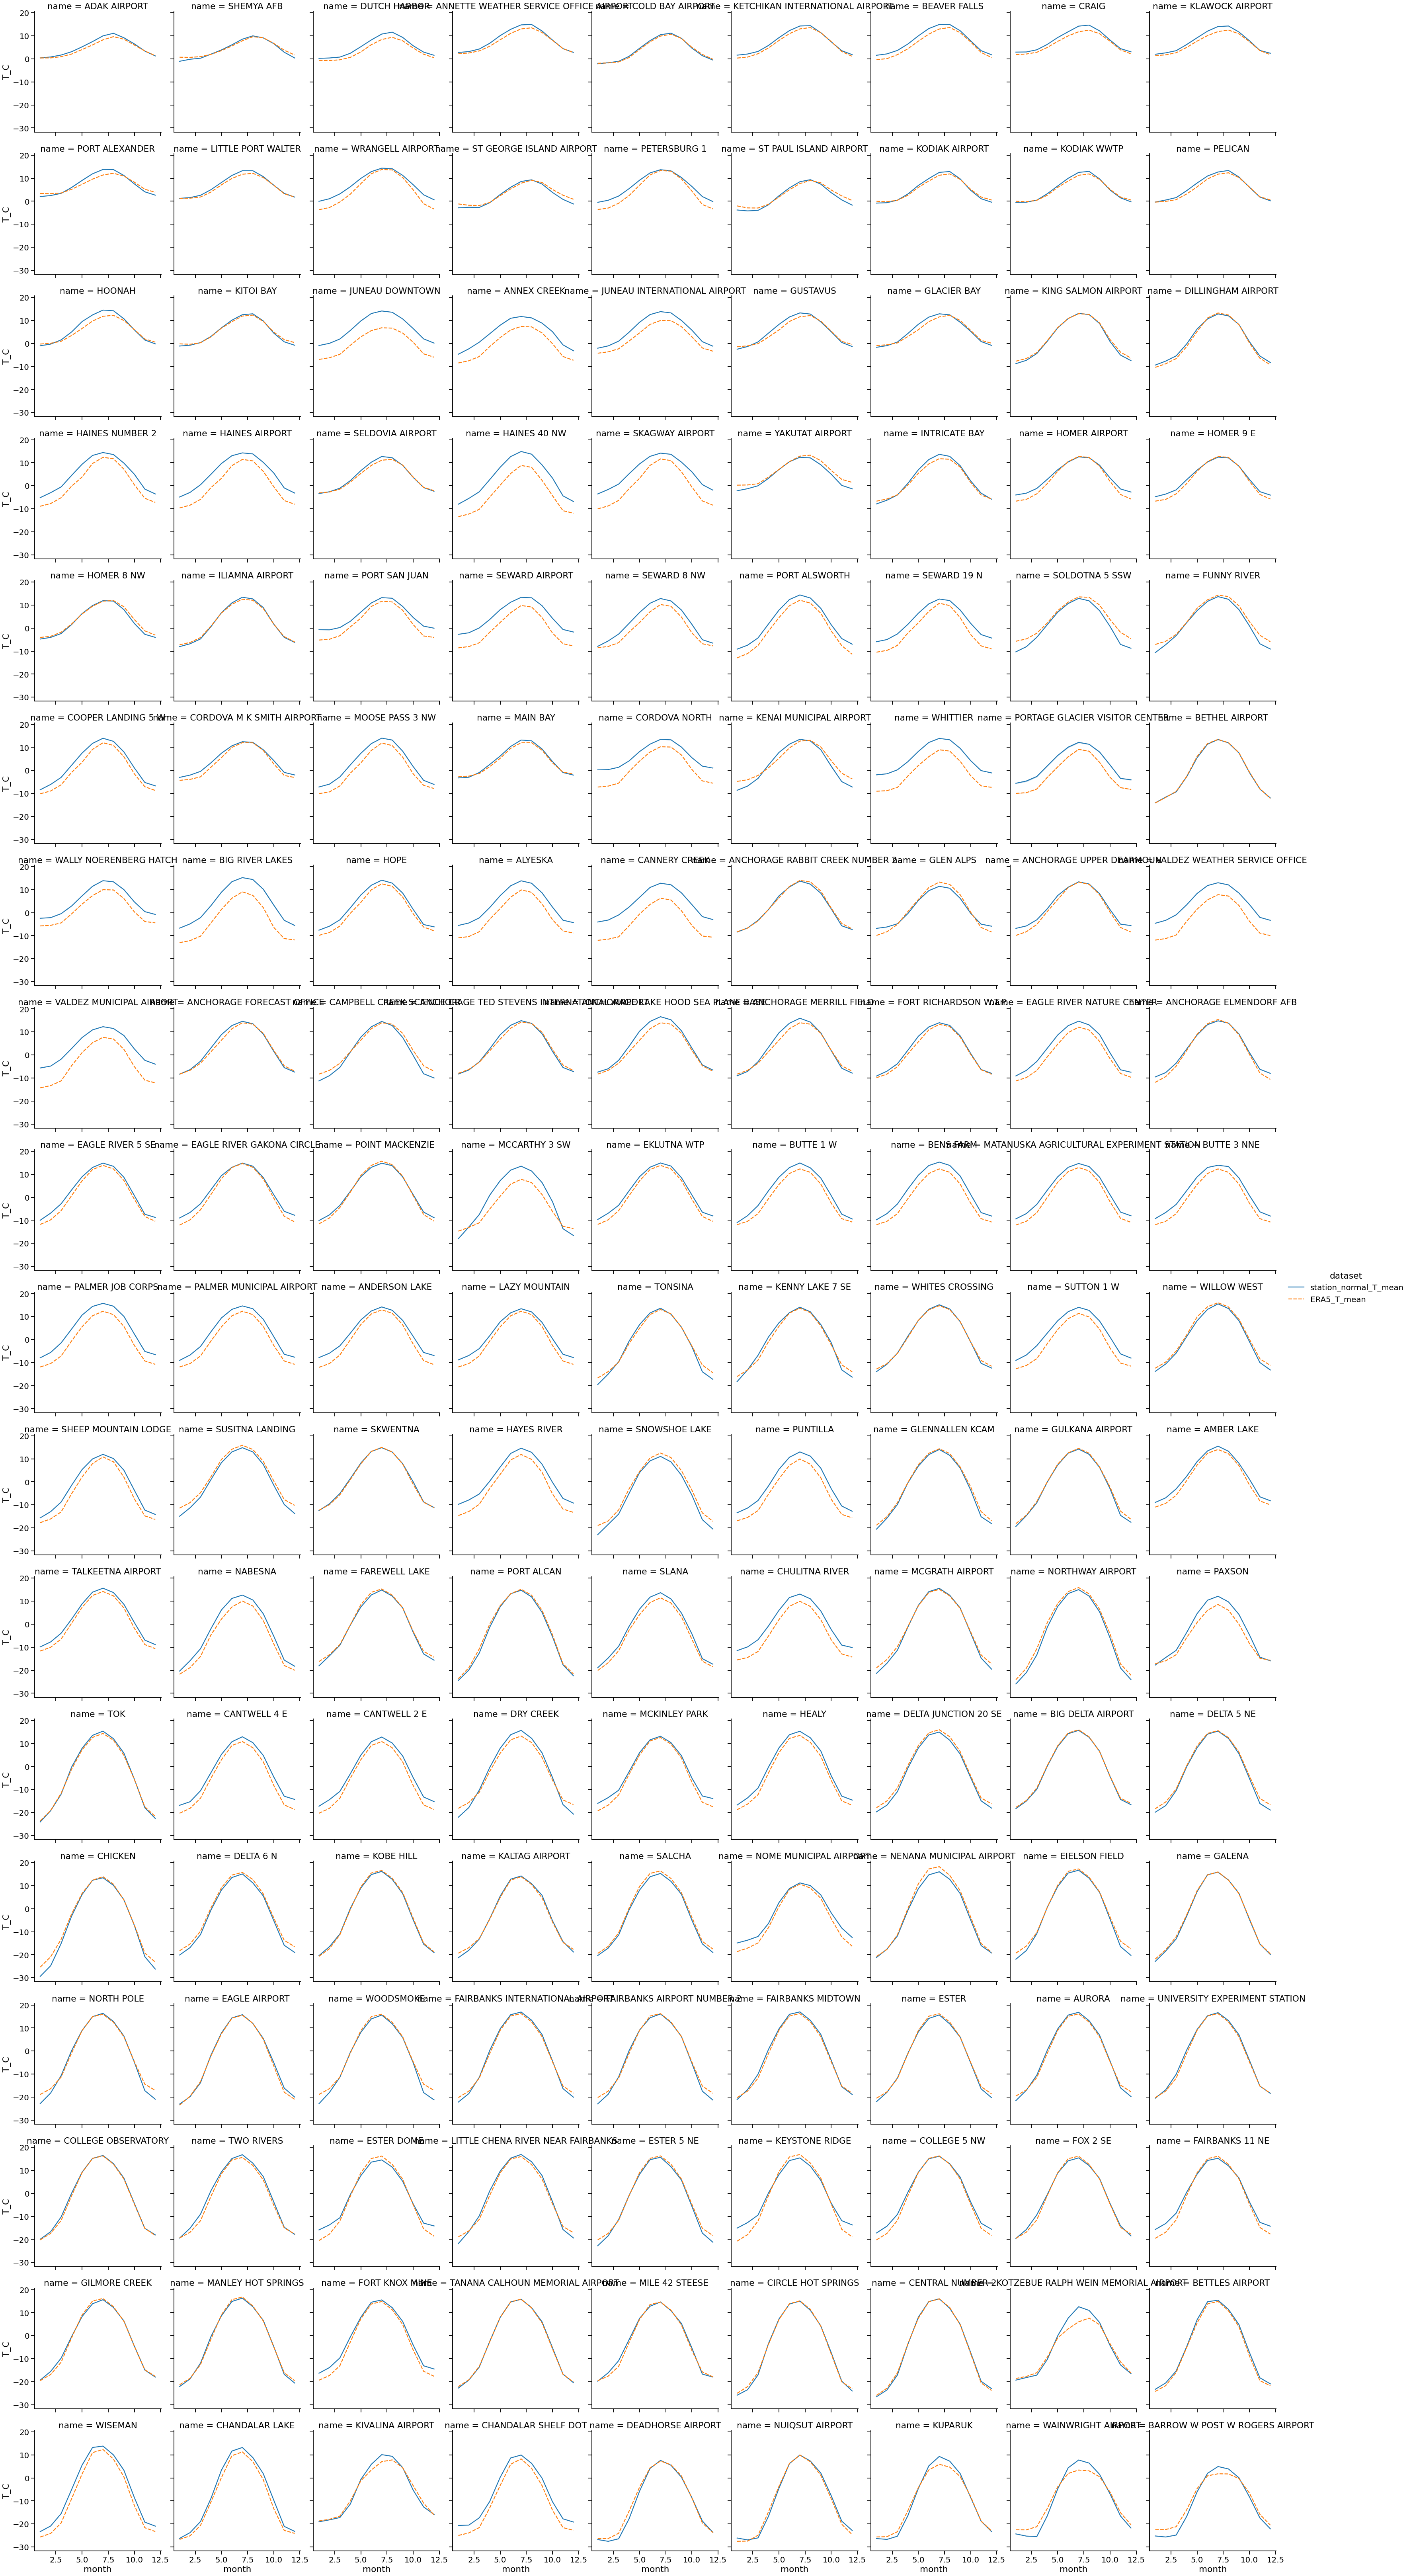

In [85]:
sns.relplot(
    data=rejigger, x="month", y="T_C", col="name",
    hue="dataset", style="dataset", kind="line",
    col_wrap=9
)

In [86]:
data_forheatmap = joint_data.loc[:, ['name', 'lat', 'lon', 'month', 'station_normal_T_mean', 'ERA5_T_mean']]
data_forheatmap['delta_T_avg'] = data_forheatmap['ERA5_T_mean'] - data_forheatmap['station_normal_T_mean']
data_forheatmap['name'] = (data_forheatmap['name']
                           .str.replace("AIRPORT", "AP")
                           .str.replace("LAKE", "LK")
                           .str.replace("INTERNATIONAL", "INT")
                           .str.replace("MEMORIAL", "MEM")
                           .str.replace("SPRINGS", "SPR")
                           .str.replace("MOUNTAIN", "MNT")
                           .str.replace("AGRICULTURAL", "AG")
                           .str.replace("EXPERIMENT", "EX")
                           .str.replace("STATION", "ST")
                           .str.slice(0, 15))

In [87]:
final_version = data_forheatmap.round({'delta_T_avg': 1}).pivot_table(
    values='delta_T_avg', 
    index=['name', 'lat'], 
    columns='month').sort_values(
    by='lat', ascending=False)


In [88]:
final_version.reset_index('lat', drop=True, inplace=True)

In [89]:
final_version

month             1    2    3    4    5    6    7    8    9    10   11   12
name                                                                       
BARROW W POST W  2.7  3.2  3.6  2.9  1.4 -1.1 -3.1 -2.2 -0.4  1.7  1.6  1.6
WAINWRIGHT AP    1.8  2.7  4.3  3.2  0.9 -2.5 -4.4 -3.4 -1.1  0.8  1.5  1.4
KUPARUK          0.7  1.2  1.9  2.2  0.4 -1.8 -3.4 -2.6 -1.3  0.4  0.0  0.3
NUIQSUT AP      -1.4 -0.5  1.1  2.0  0.8  0.0  0.0 -0.3 -1.0 -1.3 -1.3 -1.8
DEADHORSE AP     0.4  1.2  2.4  3.3  1.7  0.3 -0.3  0.2  0.5 -0.1 -0.9 -0.1
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
COLD BAY AP      0.2 -0.1 -0.3 -0.5 -0.5 -0.5 -0.6 -0.5  0.0  0.4  0.5  0.3
ANNETTE WEATHER -0.5 -0.6 -0.8 -1.3 -1.8 -1.8 -1.8 -1.5 -0.6 -0.1  0.0 -0.1
DUTCH HARBOR    -0.9 -1.1 -1.2 -1.8 -2.3 -2.1 -2.4 -2.2 -1.5 -1.0 -0.9 -1.0
SHEMYA AFB       1.8  0.8  0.7 -0.1 -0.3 -0.5 -0.7 -0.4  0.1  0.1  0.9  1.3
ADAK AP          0.0 -0.4 -0.7 -1.0 -1.2 -1.4 -1.7 -1.5 -0.6 -0.5  0.0  0.1

[163 rows x 12 columns]

In [90]:
sns.set_context("talk", font_scale=1.5)

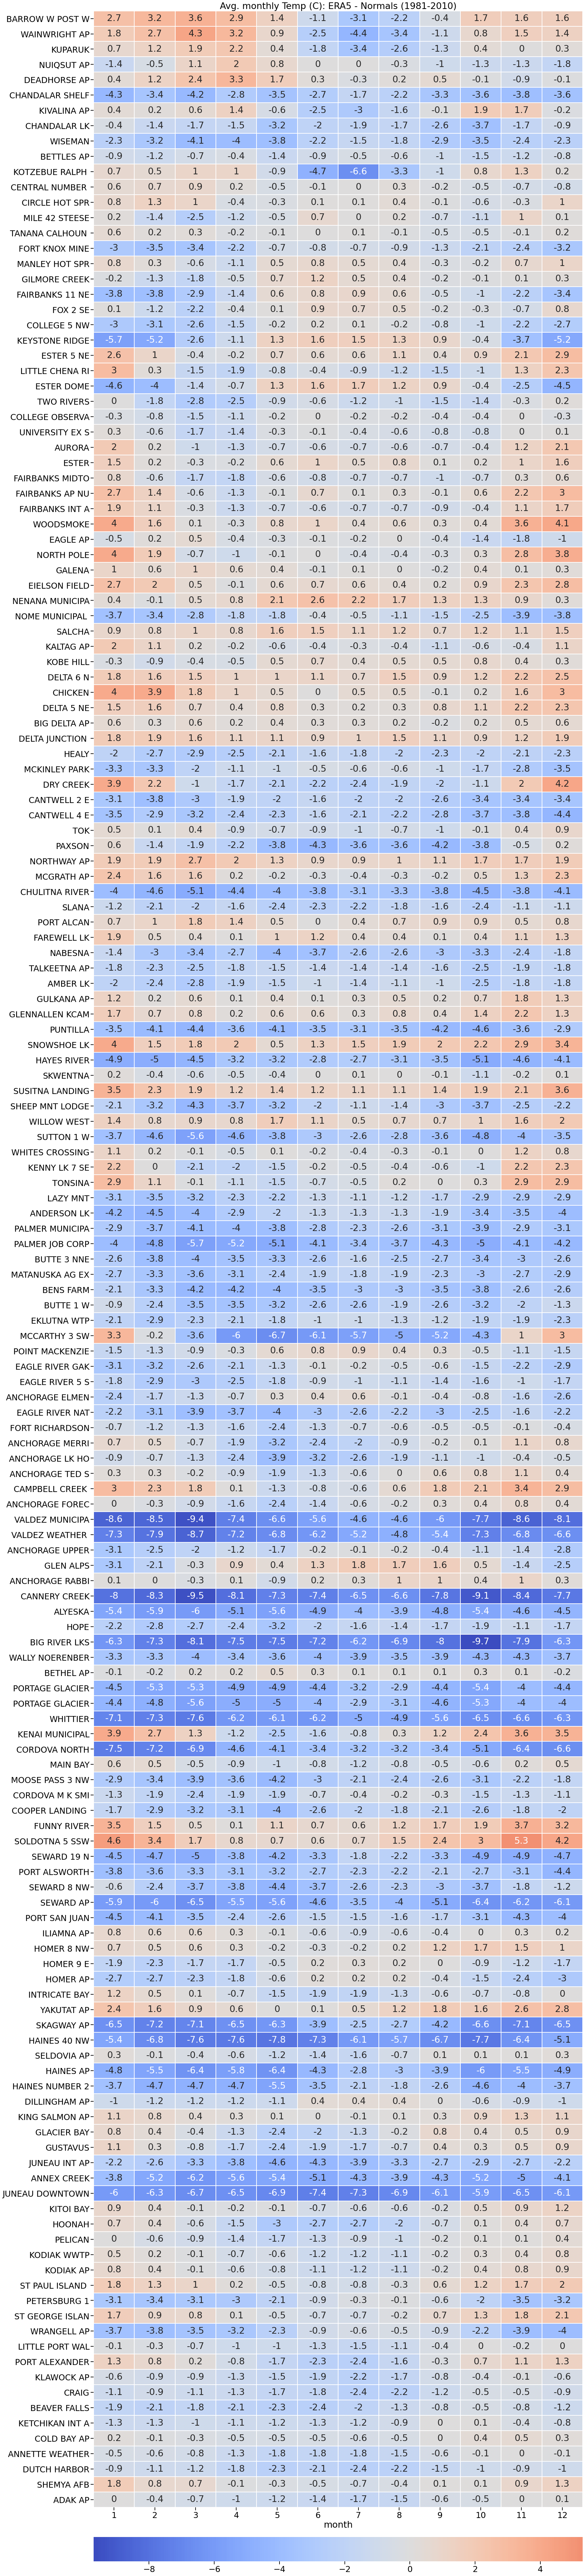

In [91]:
f, ax = plt.subplots(figsize=(25, 125))

sns.heatmap(final_version, annot=True, center=0, 
            cmap='coolwarm',
            ax=ax, cbar_kws={"orientation": "horizontal", "pad": 0.01},
           linewidths=1.5)
ax.set_ylabel('')
ax.set_title('Avg. monthly Temp (C): ERA5 - Normals (1981-2010)')
f.tight_layout()

### Saving data

Station list with ID and lat/lon

In [17]:
outdir = Path("/Volumes/CWMobileSSD/Climate/general")
outdir.mkdir(parents=True, exist_ok=True)

In [18]:
outfile = outdir / "AK_stations_for_NCEI_normals.csv"
AK_stations.reset_index(drop=True).to_csv(outfile)

In [92]:
joint_data

station                 name       lat        lon    ele  month  \
0     USC00509829             WHITTIER  60.77639 -148.68583   18.3      1   
1     USC00503720                 HOPE  60.89830 -149.62860   54.9      1   
2     USW00025506      ILIAMNA AIRPORT  59.74940 -154.90890   43.6      1   
3     USC00504812            KITOI BAY  58.19130 -152.37220   18.3      1   
4     USW00025503  KING SALMON AIRPORT  58.68290 -156.65630   20.4      1   
...           ...                  ...       ...        ...    ...    ...   
1975  USC00508594        SNOWSHOE LAKE  62.03020 -146.69300  704.7     11   
1976  USC00507141              PELICAN  57.95770 -136.22130    3.7     11   
1977  USC00503181             FOX 2 SE  64.95910 -147.62610  236.2     12   
1978  USC00508594        SNOWSHOE LAKE  62.03020 -146.69300  704.7     12   
1979  USC00507141              PELICAN  57.95770 -136.22130    3.7     12   

      station_normal_T_mean  ERA5_T_mean  
0                 -1.944444    -9.077124  
1                 -7.611111    -9.852026  
2                 -8.055556    -7.258734  
3                 -1.111111    -0.175848  
4                 -8.777778    -7.700049  
...                     ...          ...  
1975             -16.444444   -13.503577  
1976               1.777778     1.903772  
1977             -18.500000   -17.714713  
1978             -20.500000   -17.121893  
1979               0.166667     0.555505  

[1980 rows x 8 columns]

In [95]:
joint_data[joint_data.duplicated()]

station                            name       lat        lon   ele  \
981   USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
982   USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1002  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1003  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1023  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1024  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1044  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1045  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1065  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1066  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1086  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1087  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1107  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1108  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1128  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1129  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1149  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1150  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1170  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1171  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1191  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1192  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   
1212  USW00026492  PORTAGE GLACIER VISITOR CENTER  60.78500 -148.83889  31.4   
1213  USC00507502  PORTAGE GLACIER VISITOR CENTER  60.78333 -148.83333  32.0   

      month  station_normal_T_mean  ERA5_T_mean  
981       1              -5.555556   -10.021948  
982       1              -5.666667   -10.021948  
1002      2              -4.388889    -9.689764  
1003      2              -4.888889    -9.689764  
1023      3              -2.833333    -8.095282  
1024      3              -2.500000    -8.095282  
1044      4               1.833333    -3.043250  
1045      4               2.000000    -3.043250  
1065      5               6.444444     1.520746  
1066      5               6.500000     1.520746  
1086      6              10.277778     5.905054  
1087      6               9.888889     5.905054  
1107      7              12.333333     9.119775  
1108      7              12.000000     9.119775  
1128      8              11.277778     8.329523  
1129      8              11.388889     8.329523  
1149      9               7.833333     3.477991  
1150      9               8.111111     3.477991  
1170     10               2.388889    -2.994299  
1171     10               2.277778    -2.994299  
1191     11              -3.500000    -7.503363  
1192     11              -3.500000    -7.503363  
1212     12              -3.888889    -8.282629  
1213     12              -4.277778    -8.282629

In [96]:
joint_data.drop_duplicates()

station                 name       lat        lon    ele  month  \
0     USC00509829             WHITTIER  60.77639 -148.68583   18.3      1   
1     USC00503720                 HOPE  60.89830 -149.62860   54.9      1   
2     USW00025506      ILIAMNA AIRPORT  59.74940 -154.90890   43.6      1   
3     USC00504812            KITOI BAY  58.19130 -152.37220   18.3      1   
4     USW00025503  KING SALMON AIRPORT  58.68290 -156.65630   20.4      1   
...           ...                  ...       ...        ...    ...    ...   
1975  USC00508594        SNOWSHOE LAKE  62.03020 -146.69300  704.7     11   
1976  USC00507141              PELICAN  57.95770 -136.22130    3.7     11   
1977  USC00503181             FOX 2 SE  64.95910 -147.62610  236.2     12   
1978  USC00508594        SNOWSHOE LAKE  62.03020 -146.69300  704.7     12   
1979  USC00507141              PELICAN  57.95770 -136.22130    3.7     12   

      station_normal_T_mean  ERA5_T_mean  
0                 -1.944444    -9.077124  
1                 -7.611111    -9.852026  
2                 -8.055556    -7.258734  
3                 -1.111111    -0.175848  
4                 -8.777778    -7.700049  
...                     ...          ...  
1975             -16.444444   -13.503577  
1976               1.777778     1.903772  
1977             -18.500000   -17.714713  
1978             -20.500000   -17.121893  
1979               0.166667     0.555505  

[1956 rows x 8 columns]

In [102]:
monthmap = dict(zip(
    range(1, 13),
    ['DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF']
))
set(monthmap.values())
                

{'DJF', 'JJA', 'MAM', 'SON'}

In [113]:
data_by_season = joint_data.copy().drop_duplicates()
data_by_season['season'] = data_by_season['month'].map(monthmap)
data_by_season['Tmean_ERA_minus_normal'] = data_by_season['ERA5_T_mean'] - data_by_season['station_normal_T_mean']
grouped = data_by_season.groupby(['station', 'name', 'lat', 'lon', 'season', ])['Tmean_ERA_minus_normal'].mean().reset_index()

data_by_season_avg = pd.DataFrame(grouped)
data_by_season_avg

station             name       lat        lon season  \
0    USC00500243          ALYESKA  60.95830 -149.11080    DJF   
1    USC00500243          ALYESKA  60.95830 -149.11080    JJA   
2    USC00500243          ALYESKA  60.95830 -149.11080    MAM   
3    USC00500243          ALYESKA  60.95830 -149.11080    SON   
4    USC00500247       AMBER LAKE  62.19250 -150.50330    DJF   
..           ...              ...       ...        ...    ...   
647  USW00027515  NUIQSUT AIRPORT  70.21167 -151.00167    SON   
648  USW00045715       SHEMYA AFB  52.71667  174.10000    DJF   
649  USW00045715       SHEMYA AFB  52.71667  174.10000    JJA   
650  USW00045715       SHEMYA AFB  52.71667  174.10000    MAM   
651  USW00045715       SHEMYA AFB  52.71667  174.10000    SON   

     Tmean_ERA_minus_normal  
0                 -5.271784  
1                 -4.280333  
2                 -5.552239  
3                 -4.979598  
4                 -2.073890  
..                      ...  
647               -1.228191  
648                1.295197  
649               -0.528543  
650                0.090572  
651                0.364151  

[652 rows x 6 columns]

In [115]:
data_by_season_avg = gp.GeoDataFrame(
    data_by_season_avg, crs="EPSG:4326", geometry=gp.points_from_xy(data_by_season_avg.lon, data_by_season_avg.lat))

In [117]:
data_by_season_avg.to_file(outdir / 'delta_Tmean_ERA5_normals.gpkg')

/var/folders/48/f3lkqht50nd1rrkd8xn0vlk40000gn/T/ipykernel_24963/4175659259.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data_by_season_avg.to_file(outdir / 'delta_Tmean_ERA5_normals.gpkg')


In [118]:
outdir

PosixPath('/Volumes/CWMobileSSD/Climate/general')

In [119]:
data_by_season_avg

station             name       lat        lon season  \
0    USC00500243          ALYESKA  60.95830 -149.11080    DJF   
1    USC00500243          ALYESKA  60.95830 -149.11080    JJA   
2    USC00500243          ALYESKA  60.95830 -149.11080    MAM   
3    USC00500243          ALYESKA  60.95830 -149.11080    SON   
4    USC00500247       AMBER LAKE  62.19250 -150.50330    DJF   
..           ...              ...       ...        ...    ...   
647  USW00027515  NUIQSUT AIRPORT  70.21167 -151.00167    SON   
648  USW00045715       SHEMYA AFB  52.71667  174.10000    DJF   
649  USW00045715       SHEMYA AFB  52.71667  174.10000    JJA   
650  USW00045715       SHEMYA AFB  52.71667  174.10000    MAM   
651  USW00045715       SHEMYA AFB  52.71667  174.10000    SON   

     Tmean_ERA_minus_normal                     geometry  
0                 -5.271784  POINT (-149.11080 60.95830)  
1                 -4.280333  POINT (-149.11080 60.95830)  
2                 -5.552239  POINT (-149.11080 60.95830)  
3                 -4.979598  POINT (-149.11080 60.95830)  
4                 -2.073890  POINT (-150.50330 62.19250)  
..                      ...                          ...  
647               -1.228191  POINT (-151.00167 70.21167)  
648                1.295197   POINT (174.10000 52.71667)  
649               -0.528543   POINT (174.10000 52.71667)  
650                0.090572   POINT (174.10000 52.71667)  
651                0.364151   POINT (174.10000 52.71667)  

[652 rows x 7 columns]

In [38]:
AK_normals_df

STATION      NAME  LATITUDE  LONGITUDE  ELEVATION  DATE  \
0     USC00509829  WHITTIER  60.77639 -148.68583       18.3     1   
1     USC00509829  WHITTIER  60.77639 -148.68583       18.3     2   
2     USC00509829  WHITTIER  60.77639 -148.68583       18.3     3   
3     USC00509829  WHITTIER  60.77639 -148.68583       18.3     4   
4     USC00509829  WHITTIER  60.77639 -148.68583       18.3     5   
...           ...       ...       ...        ...        ...   ...   
2059  USC00507141   PELICAN  57.95770 -136.22130        3.7     8   
2060  USC00507141   PELICAN  57.95770 -136.22130        3.7     9   
2061  USC00507141   PELICAN  57.95770 -136.22130        3.7    10   
2062  USC00507141   PELICAN  57.95770 -136.22130        3.7    11   
2063  USC00507141   PELICAN  57.95770 -136.22130        3.7    12   

      MLY-DUTR-NORMAL MLY-DUTR-NORMAL_ATTRIBUTES  MLY-DUTR-STDDEV  \
0                 7.7                          S              1.7   
1                 7.5                          S              1.6   
2                 8.3                          S              1.2   
3                 9.8                          S              1.1   
4                11.8                          S              2.0   
...               ...                        ...              ...   
2059             12.5                          R              3.2   
2060             12.4                          R              2.6   
2061             10.0                          R              1.3   
2062              8.4                          R              1.4   
2063              7.5                          R              1.1   

     MLY-DUTR-STDDEV_ATTRIBUTES  ...  MLY-TMIN-PRBOCC-LSTH024  \
0                             S  ...                    990.0   
1                             S  ...                    992.0   
2                             S  ...                    954.0   
3                             S  ...                    477.0   
4                             S  ...                      0.0   
...                         ...  ...                      ...   
2059                          R  ...                      0.0   
2060                          R  ...                      0.0   
2061                          R  ...                    122.0   
2062                          R  ...                    679.0   
2063                          R  ...                    950.0   

     MLY-TMIN-PRBOCC-LSTH024_ATTRIBUTES  MLY-TMIN-PRBOCC-LSTH028  \
0                                     S                    999.0   
1                                     S                    999.0   
2                                     S                    996.0   
3                                     S                    764.0   
4                                     S                      0.0   
...                                 ...                      ...   
2059                                  R                      0.0   
2060                                  R                     10.0   
2061                                  R                    463.0   
2062                                  R                    931.0   
2063                                  R                   1000.0   

     MLY-TMIN-PRBOCC-LSTH028_ATTRIBUTES  MLY-TMIN-PRBOCC-LSTH032  \
0                                     S                   1000.0   
1                                     S                   1000.0   
2                                     S                   1000.0   
3                                     S                    974.0   
4                                     S                    192.0   
...                                 ...                      ...   
2059                                  R                      0.0   
2060                                  R                    139.0   
2061                                  R                    898.0   
2062                                  R                    995.0   
2063  